# 3D bounding box model

In this notebook, we design the model that takes training images and 2D bounding box information and outputs 3D bounding boxes.

In [15]:
# Import statements.
from data_processing import parse_annotation, data_gen
from dataset import TRAIN_KEY, VAL_KEY, LABEL_DIR, TRAIN_IMAGE_DIR, \
    get_train_only_kitti_partition
import os
import numpy as np
from typing import Dict, Any, List
import tensorflow as tf
from tensorflow.keras import backend as K
from tensorflow.keras import Model
from tensorflow.keras.callbacks import History
from tensorflow.keras.layers import Conv2D, MaxPool2D, Flatten, Dense, \
    LeakyReLU, Dropout, Reshape, Softmax, Input, Lambda
from tensorflow.keras.applications import VGG16
from tensorflow.keras.utils import plot_model

In [2]:
# Global constants.
VGG_INPUT_SHAPE = (224, 224, 3)
DIM_OUT_SHAPE = 3
ORIENT_OUT_SHAPE = (2, 2)
CONF_OUT_SHAPE = 2
DEFAULT_MODEL_ARGS = {'input_shape': (224, 224, 3)}
DEFAULT_TRAIN_ARGS = {'epochs': 5,
                      'batch_size': 32,
                      'use_tensorboard': False,
                      'model_checkpoint_filename': None}

In [3]:
def orientation_loss(y_true: np.ndarray, y_pred: np.ndarray) -> tf.Tensor:
    """Returns the orientation loss from the predictions.
    :param y_true: The true orientation, a tensor of shape (None, 2, 2).
    :param y_pred: The predicted orientation of the same shape.
    :return: The orientation loss as a tensor.
    """
    anchors = tf.reduce_sum(tf.square(y_true), axis=2)
    anchors = tf.greater(anchors, tf.constant(0.5))
    anchors = tf.reduce_sum(tf.cast(anchors, tf.float32), 1)
    loss = (y_true[:, :, 0] * y_pred[:, :, 0] + y_true[:, :, 1] * \
            y_pred[:, :, 1])
    loss = tf.reduce_sum((2 - 2 * tf.reduce_mean(loss, axis=0))) / anchors
    return tf.reduce_mean(loss)

In [13]:
def get_model_3d_deepbox() -> Model:
    """Returns the model used in the 3D-deepbox paper. Uses a VGG16 base. The
    model takes as input images of shape VGG_INPUT_SHAPE and outputs 3 tensors:
    dimensions (None, 3), orientation (None, 2, 2), confidence (None, 2).
    :return: The model.
    """
    vgg = VGG16(weights='imagenet', include_top=False,
                input_shape=VGG_INPUT_SHAPE)
    conv5 = Flatten()(vgg.output)
    dim_out = Dense(512, activation=None)(conv5)
    dim_out = LeakyReLU(alpha=0.1)(dim_out)
    dim_out = Dropout(rate=0.5)(dim_out)
    dim_out = Dense(DIM_OUT_SHAPE, activation=None)(dim_out)
    orient_out = Dense(256, activation=None)(conv5)
    orient_out = LeakyReLU(alpha=0.1)(orient_out)
    orient_out = Dropout(rate=0.5)(orient_out)
    orient_out = Dense(ORIENT_OUT_SHAPE[0] * ORIENT_OUT_SHAPE[1],
                       activation=None)(orient_out)
    orient_out = Reshape((ORIENT_OUT_SHAPE[0], ORIENT_OUT_SHAPE[1]))(orient_out)
    orient_out = Lambda(lambda x: K.l2_normalize(x, axis=2))(orient_out)
    conf_out = Dense(256, activation=None)(conv5)
    conf_out = LeakyReLU(alpha=0.1)(conf_out)
    conf_out = Dropout(rate=0.5)(conf_out)
    conf_out = Dense(CONF_OUT_SHAPE, activation=None)(conf_out)
    conf_out = Softmax()(conf_out)
    model = Model(inputs=vgg.input, outputs=[dim_out, orient_out, conf_out])
    model.compile(loss=[tf.keras.losses.mean_squared_error,
                        orientation_loss,
                        tf.keras.losses.categorical_crossentropy],
                  loss_weights=[4, 8, 1],
                  optimizer='adam')
    return model

In [16]:
def train(model: Model,
          partition: Dict[str, List[str]],
          image_dir: str,
          label_dir: str,
          train_args: Dict[str, Any] = DEFAULT_TRAIN_ARGS) -> History:
    """Trains the model and returns the history.
    :param model: The model.
    :param partition: The partition.
    :param image_dir: The directory in which the training images are stored.
    :param label_dir: The directory in which the labels are stored.
    :param train_args: A dictionary specifying the training hyperparameters.
    :return: The training history object.    
    """
    train_objs = parse_annotation(partition[TRAIN_KEY], label_dir)
    val_objs = parse_annotation(partition[VAL_KEY], label_dir)
    np.random.shuffle(train_objs)
    np.random.shuffle(val_objs)
    train_gen = data_gen(image_dir, train_objs, train_args['batch_size'])
    val_gen = data_gen(image_dir, val_objs, train_args['batch_size'])
    train_steps = int(np.ceil(len(train_objs) / train_args['batch_size']))
    val_steps = int(np.ceil(len(val_objs) / train_args['batch_size']))
    callbacks = []
    if train_args['use_tensorboard']:
        log_dir = 'logs_{0}'.format(datetime.now())
        tensorboard_callback = TensorBoard(log_dir=log_dir)
        callbacks.append(tensorboard_callback)
    if train_args['model_checkpoint_filename']:
        checkpoint_callback = ModelCheckpoint(
            train_args['model_checkpoint_filename'],
            save_best_only=True)
        callbacks.append(checkpoint_callback) 
    return model.fit(
        x=train_gen,
        epochs=train_args['epochs'],
        callbacks=callbacks,
        validation_data=val_gen,
        steps_per_epoch=train_steps,
        validation_steps=val_steps)

In [6]:
def evaluate(model, partition, labels, image_dir) -> Dict[str, Any]:
    # TODO
    return None

In [7]:
def predict(model, image_paths):
    # TODO
    return None

In [8]:
partition = get_train_only_kitti_partition(TRAIN_IMAGE_DIR)

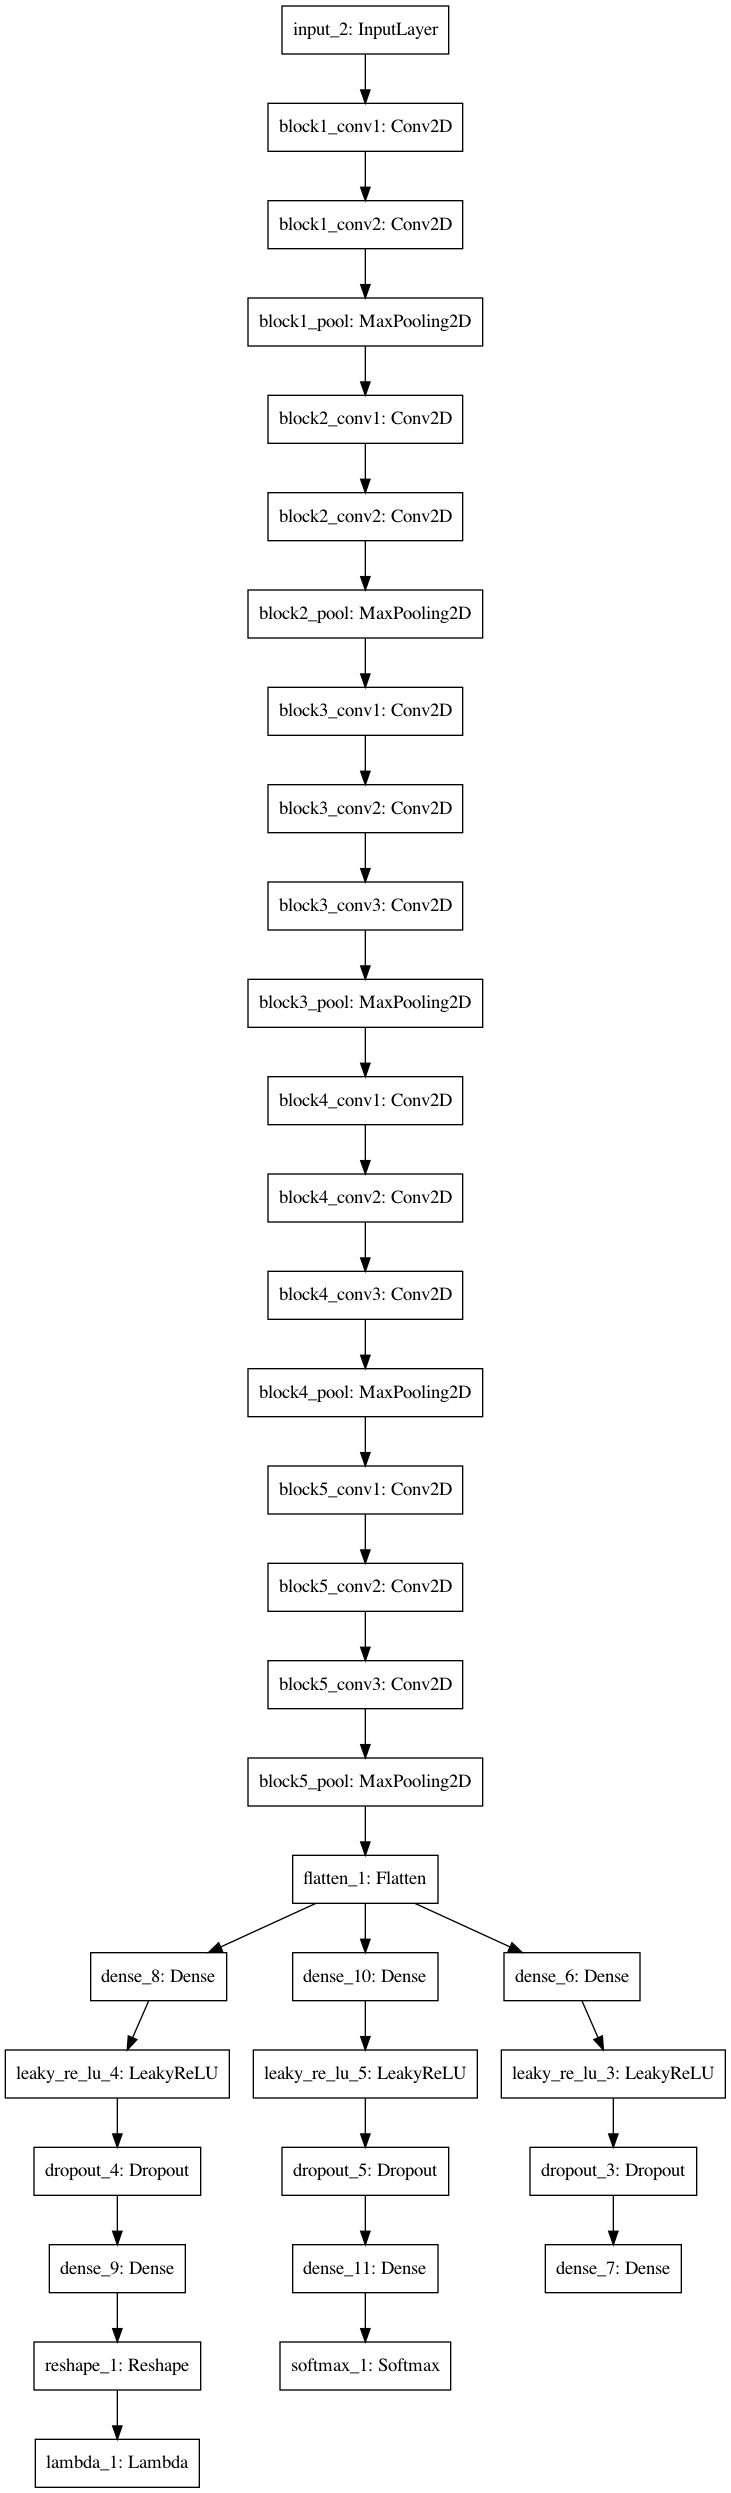

In [12]:
model = get_model_3d_deepbox()
plot_model(model)

In [10]:
train_args = DEFAULT_TRAIN_ARGS
train_args['model_checkpoint_filename'] = os.path.join('model',
                                                       'model_3d_deepbox.h5')
train(model, partition, TRAIN_IMAGE_DIR, LABEL_DIR)

Epoch 1/5
 18/346 [>.............................] - ETA: 53:22 - loss: 856.1291 - dense_1_loss: 206.8861 - lambda_loss: 3.0787 - softmax_loss: 3.9550

KeyboardInterrupt: 